In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from N_gram import N_gram_Component
from metrics import run_metrics

data_1 = pd.read_csv("data/BATADAL_dataset03.csv")
data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")
test_data = pd.read_csv("data/BATADAL_test_dataset.csv")

data_1["DATETIME"] = pd.to_datetime(data_1.DATETIME)
data_2["DATETIME"] = pd.to_datetime(data_2.DATETIME)
test_data["DATETIME"] = pd.to_datetime(test_data.DATETIME)

# Selecting a subset of signals
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'F_PU2', 'S_PU2', 'F_PU4', 'S_PU4',
       'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
       # make test data
import datetime
test_data['ATT_FLAG'] = pd.Series(np.zeros(test_data.shape[0])) # default 0 (no-attack)

# start setting values
attack_times = [
    [pd.Timestamp("2017-01-16T09"), pd.Timestamp("2017-01-19T06")],
    [pd.Timestamp("2017-01-30T08"), pd.Timestamp("2017-02-02T00")],
    [pd.Timestamp("2017-02-09T03"), pd.Timestamp("2017-02-10T09")],
    [pd.Timestamp("2017-02-12T01"), pd.Timestamp("2017-02-13T07")],
    [pd.Timestamp("2017-02-24T05"), pd.Timestamp("2017-02-28T08")],
    [pd.Timestamp("2017-03-10T14"), pd.Timestamp("2017-03-13T21")],
    [pd.Timestamp("2017-03-25T20"), pd.Timestamp("2017-03-27T01")]
]

for times in attack_times:
    indexes = np.where(test_data['DATETIME'].between(times[0], times[1], inclusive=True))[0]
    test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)

X = data_1[signals].to_numpy()

### Discretization

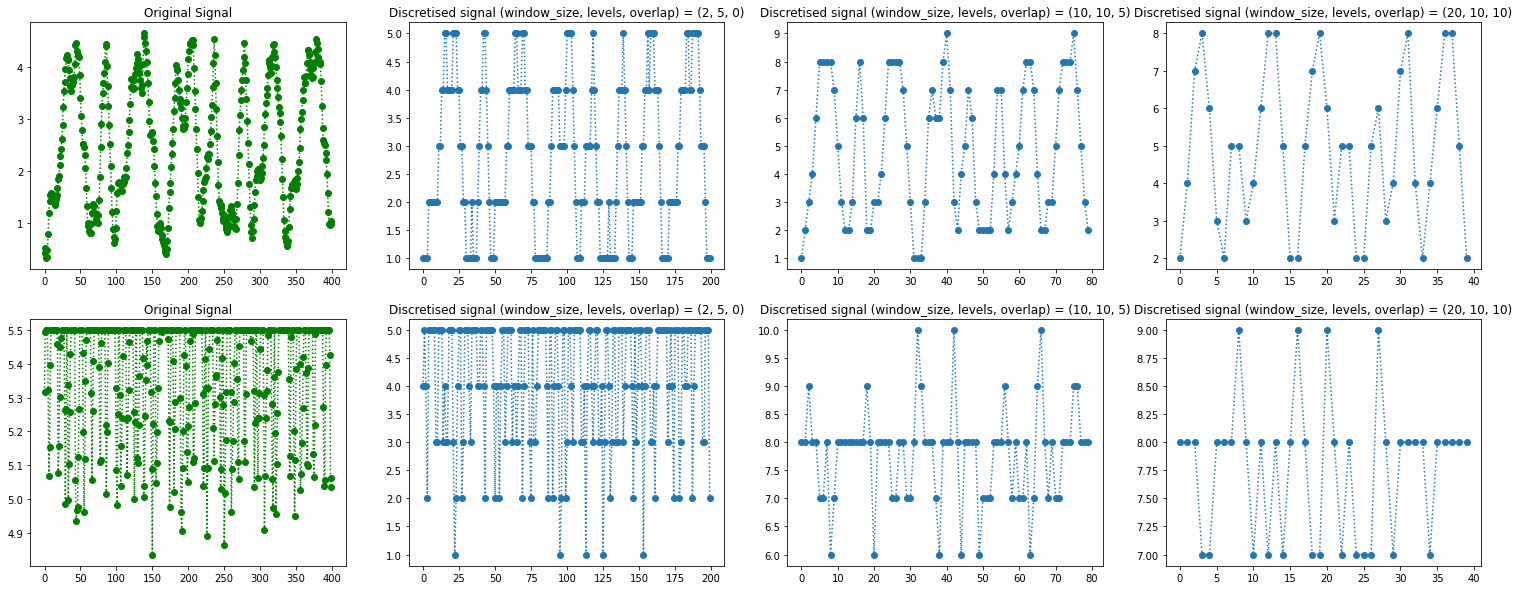

In [40]:
N_gram = N_gram_Component(2, len(signals))

# Plot
# different window_size and overlap
params = np.array([[2, 5, 1], [10, 10, 5], [20, 10, 10]])
fig, axs = plt.subplots(2,4)
fig.set_size_inches((26,10))
x_range = 400
axs[0,0].set_title('Original Signal')
axs[0,0].plot(range(x_range), X[0:x_range, 0], 'o:g')
axs[1,0].set_title('Original Signal')
axs[1,0].plot(range(x_range), X[0:x_range, 5], 'o:g')

for i in range(np.shape(params)[0]):
    X_windowed = N_gram.discretise(X, window_size=params[i,0], levels =params[i,1],  overlap=params[i,2])
    x_range_ = x_range / (params[i,0] - params[i,2])
    axs[0,i+1].set_title('Discretised signal (window_size, levels, overlap) = (' + str(params[i,0])+', '+str(params[i,1])+', '+str(params[i,2])+")")
    axs[0,i+1].plot(range(int(x_range_)), X_windowed[0:int(x_range_), 0], 'o:')
    axs[1,i+1].set_title('Discretised signal (window_size, levels, overlap) = (' + str(params[i,0])+', '+str(params[i,1])+', '+str(params[i,2])+")")
    axs[1,i+1].plot(range(int(x_range_)), X_windowed[0:int(x_range_), 5], 'o:')

plt.show()

Lets select discretization parameters (window_size, levels, overlap) as (2, 10, 1)

### Selct $L$ and $N$ now

In [41]:
# Z is dataset_2
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]

Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]
Z_outlier_labels = Z_labels[Z_outlier_indexes]
Z_inlier_labels = np.zeros(len(Z_inlier_indexes))

# discretization is done only once 
params = (2,5,1)
Z_inlier_windowed = N_gram.discretise(Z_inliers, window_size=params[0], levels=params[1],  overlap=params[2])
Z_outlier_windowed = N_gram.discretise(Z_outliers, window_size=params[0], levels=params[1],  overlap=params[2])

Z_inlier_labels = N_gram.discretise_labels(Z_inlier_labels, window_size=params[0], overlap=params[2])
Z_outlier_labels = N_gram.discretise_labels(Z_outlier_labels, window_size=params[0], overlap=params[2])

In [42]:
test_X = test_data[signals].to_numpy()
test_X_windowed = N_gram.discretise(test_X, window_size=params[0], levels=params[1],  overlap=params[2])
test_Y = test_data['ATT_FLAG'].to_numpy()
test_Y_windowed = N_gram.discretise_labels(test_Y, window_size=params[0], overlap=params[2])
print(test_X.shape)
print(test_Y.shape)

(2089, 43)
(2089,)


In [43]:
acc = []
auc = []
L_arr = [10, 20, 30] # above 20 it we highly undersample anomaly class
for L in L_arr:
    acc_ = []
    auc_ = []
    for N in range(1,5): # only upto 4 due to high processing time
        N_gram = N_gram_Component(N, len(signals))
        Z_in_profiles = N_gram.generate_profiles(Z_inlier_windowed, L)
        Z_in_profile_labels = N_gram.generate_profile_labels(Z_inlier_labels, L)

        Z_out_profiles = N_gram.generate_profiles(Z_outlier_windowed, L)
        Z_out_profile_labels = N_gram.generate_profile_labels(Z_outlier_labels, L)

        # Stack train data together for training k-NearestNeighbour
        train_X = np.vstack((Z_in_profiles, Z_out_profiles))
        train_Y = np.vstack((Z_in_profile_labels, Z_out_profile_labels))


        test_X_profiles = N_gram.generate_profiles(test_X_windowed, L)
        test_X_profile_labels = N_gram.generate_profile_labels(test_Y_windowed, L)

        N_gram.fit_kNN(train_X, train_Y)
        y_pred = N_gram.classify(test_X_profiles, L)

        result = run_metrics(test_X_profile_labels, y_pred)
        acc_.append(result['accuracy']) 
        auc_.append(result['auc']) 
        print(str([L,N]) + " done")
    acc.append(acc_)
    auc.append(auc_)
print("Completed :)")

[10, 1] done
[10, 2] done
[10, 3] done
[10, 4] done
[20, 1] done
[20, 2] done
[20, 3] done
[20, 4] done
[30, 1] done
[30, 2] done
[30, 3] done
[30, 4] done
Completed :)


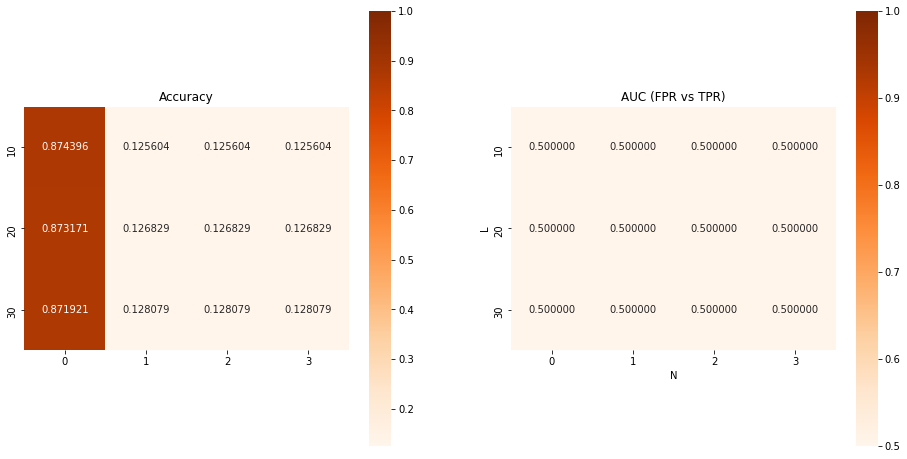

In [44]:
import seaborn as sns
fig, axs = plt.subplots(1, 2,figsize=(16,8))
axs[0].set_title("Accuracy")
sns.heatmap(acc, square=True, annot=True, fmt=".6f", cmap='Oranges', vmax=1, xticklabels=range(0,4), ax=axs[0], yticklabels=L_arr)
axs[1].set_title("AUC (FPR vs TPR)")
sns.heatmap(auc, square=True, annot=True, fmt=".6f", cmap='Oranges', vmax=1, xticklabels=range(0,4), ax=axs[1], yticklabels=L_arr)
plt.xlabel('N')
plt.ylabel('L')
plt.show()

### Explaination
After discretization I tried combinations of L and N. For every block L I calculated N-Gram grequencies and made a profile signature. I found matching labels for this too. I used dataset 2 to charactersise normal and anomalous signatures. Using dataset1 causes heavy oversampling of the normal class.

Clearly there are a lot of things to optimise:
window_size, discretization levels, overlap, L, N, k in k-NN, minory class sampling... thus it proved to be quite difficult to optimise. Looking at the AUC the k-NN is clearly biased and always classifies as either always all 1s or all 0s

## Task 6 material

In [45]:
#Make train and test data
# Z is dataset_2
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'F_PU2', 'S_PU2', 'F_PU4', 'S_PU4',
       'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]

Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]
Z_outlier_labels = Z_labels[Z_outlier_indexes]
Z_inlier_labels = np.zeros(len(Z_inlier_indexes))

L = 20
N = 1
N_gram = N_gram_Component(N, len(signals))

# discretization is done only once 
params = (2,5,1)
Z_inlier_windowed = N_gram.discretise(Z_inliers, window_size=params[0], levels=params[1],  overlap=params[2])
Z_outlier_windowed = N_gram.discretise(Z_outliers, window_size=params[0], levels=params[1],  overlap=params[2])

Z_inlier_labels = N_gram.discretise_labels(Z_inlier_labels, window_size=params[0], overlap=params[2])
Z_outlier_labels = N_gram.discretise_labels(Z_outlier_labels, window_size=params[0], overlap=params[2])

test_X = test_data[signals].to_numpy()
test_X_windowed = N_gram.discretise(test_X, window_size=params[0], levels=params[1],  overlap=params[2])
test_Y = test_data['ATT_FLAG'].to_numpy()
test_Y_windowed = N_gram.discretise_labels(test_Y, window_size=params[0], overlap=params[2])

In [46]:
Z_in_profiles = N_gram.generate_profiles(Z_inlier_windowed, L)
Z_in_profile_labels = N_gram.generate_profile_labels(Z_inlier_labels, L)

Z_out_profiles = N_gram.generate_profiles(Z_outlier_windowed, L)
Z_out_profile_labels = N_gram.generate_profile_labels(Z_outlier_labels, L)

# Stack train data together for training k-NearestNeighbour
train_X = np.vstack((Z_in_profiles, Z_out_profiles))
train_Y = np.vstack((Z_in_profile_labels, Z_out_profile_labels))

test_X_profiles = N_gram.generate_profiles(test_X_windowed, L)
test_X_profile_labels = N_gram.generate_profile_labels(test_Y_windowed, L)

N_gram.fit_kNN(train_X, train_Y)
y_pred = N_gram.classify(test_X_profiles, L)

result = run_metrics(test_X_profile_labels, y_pred)

In [47]:
result

{'false_pos_rate': array([0., 1.]),
 'true_pos_rate': array([0., 1.]),
 'precision_curve': array([0.12682927, 1.        ]),
 'recall_curve': array([1., 0.]),
 'auc_pr': 0.49195716835217135,
 'accuracy': 0.8731707317073171,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'auc': 0.5,
 'confusion': array([[179,   0],
        [ 26,   0]]),
 'confusion_norm': array([[0.87317073, 0.        ],
        [0.12682927, 0.        ]]),
 'tn': 179,
 'tp': 0,
 'fn': 26,
 'fp': 0}